# Machine Learning and Neural Networks

We are close to the end of the course and covered different applications of Python to physical problems. The course is not intended to teach the physics, but exercise the application of Python. One field, which is increasingly important also in physics is the field of machine learning. Machine learning is the summarizing term for a number of computational procedures to extract useful information from data. We would like to spend the rest of the course to introduce you into a tiny part of machine learning. We will do that in a way that you calculate as much as possible in pure Python without any additional packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *  
from scipy.sparse import diags
from scipy.fftpack import fft,ifft
from scipy import sparse as sparse
from scipy.sparse import linalg as ln
from time import sleep,time
import matplotlib.patches as patches
from ipycanvas import MultiCanvas, hold_canvas,Canvas


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# default values for plotting
plt.rcParams.update({'font.size': 16,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 

## Overview

Machine learning has its origins long time ago and many of the currently very popular approaches have been developed in the past century. Two things have been stimmulating the current hype of machine learning techniques. One is the computational power that is available already at the level of your smartphone. The second one is the availability of data. Machine learning is divided into different areas, which are denotes as 

- supervised learning: telling the system what is right or wrong
- semi-supervised learning: having only sparse information on what is right or wrong
- unsupervised learning: let the system figure out what is right or wrong

The graphics below gives a small summary. In our course, we cannot cover all methods. We will focus on **Reinforcement Learning** and **Neural Networks** just to show you, how things could look in Python.

![](ml_overview.png)

Image taken from F. Cichos et al. Nature Machine Intelligence (2020).

## Reinforcement Learning

Reinforcement learning is learning what to do—how to map situations to actions—so as to maximize a numerical reward signal. The learner or agent is not told which actions to take, as in most forms of machine learning, but instead must discover which actions yield the most reward by trying them. In the most interesting and challenging cases, actions may affect not only the immediate reward but also the next situation and, through that, all subsequent rewards. These two characteristics—trial-and-error search and delayed reward—are the two most important distinguishing features of reinforcement learning.

It has been around since the 1950s but gained momentum only in 2013 with the demonstrations of DeepMind on how to learn play Atari games like pong. The graphic below shows some of its applications in the field of robotics and gaming.

![overview_rl](overview_RL.png)

### Markov Decision Process

The key element of reinforcement learning is the so-called Markov Decision Process. The Markov decision process (MDP) denotes a formalism of planning actions in the face of uncertainty. A MDP consist formally of 

- $S$: a set of accessible states in the world
- $D$: an initial distribution to be in a state
- $P_{sa}$: transition probability between states
- $A$: A set of possible actions to take in each state
- $\gamma$: the discount factor, which is a number between 0 and 1
- $R$: A reward function 

We begin in an initial state $s_{i,j}$ drawn from the distribution $D$. At each time step $t$, we then have to pick an action, for example $a_1(t)$ , as a result of which our state transitions to some state  $s_{i,j+1}$. The states do not nessecarily correspond to spatial positions, however, as we talk about the gridworld later we may use this example to understand the procedures.

![gw_with_path](gw_with_path.png)

By repeatedly picking actions, we traverse some sequence of states

$$
s_{0,0}\rightarrow s_{0,1}\rightarrow s_{1,1}+\ldots
$$

Our total reward is then the sum of discounted rewards along this sequence of states

$$
R(s_{0,0})+\gamma R(s_{0,1})+ \gamma^2 R(s_{1,1})+ \ldots
$$

Here, the discount factor $\gamma$, which is typically strictly less than one, causes rewards obtained immediately to be more valuable than those obtained in the future. 

In reinforcement learning, our goal is to find a way of choosing actions $a_0$,$a_1, \ldots$ over time, so as to maximize the expected value of the rewards. The sequence of actions that realizes the maximum reward is called the optimal policy $\pi^{*}$. A sequence of actions in general is called a policy $\pi$.

#### Methods or RL

There are different methods available to find the optimal policy. If we know the transition probabilities $P_{sa}$ the methods are called model-based algorithms. The so-called value interation procedure would be one of those methods, which we, however, do not consider.

If we don't know the transition probabilities, then its model-free RL. We will have a look at one of those mode-free algorithms, which is Q‐learning.

In Q-learning, the value of an action in a state is measured by its Q-value. The expectation value $E$ of the rewards with and initial state and action for a given policy is the Q-function or Q-value. 

$$
Q^{\pi}(s,a)=E[R(s_{0},a_{0})+\gamma R(s_{1},a_{1})+ \gamma^2 R(s_{2},a_{2})+ \ldots | s_{0}=s,a_{0}=a,a_{t}=\pi(s_{t})]
$$

This sounds complicated but is in principle easy. There is  a Q-value for all actions of each state. Thus if we have 4 actions an 25 states, we have to store in total 100 Q-values. 

 For the optimal sequence of actions - for the best way to go - this Q value becomes a maximum.

$$
Q^{*}(s,a)=\max_{\pi}Q^{\pi}(s,a)
$$


The policy which gives the sequence of actions to be carried out to get the maximum reward is then calculated by


$$
\pi^{*}(s)={\rm argmax_{a}}Q^{*}(s,a)
$$

The **Q-learning** algorithm is now an iterative procedure of updating the Q-value of each state and action which converges to the optimal policy $\pi^{*}$. It is given by

$$
Q_{t+\Delta t}(s,a)  = Q_t(s,a) + \alpha\big[R(s) + \gamma \max_{a'}Q_t(s',a')-Q_t(s,a)\big]
$$

This states, that the current Q-value of the current state $s$ and the taken action $a$ for the next step is calculated from its current value $Q_t(s,a)$ plus an update value. This update value is calculated by multiplying the so-called learing rate $\alpha$ with the reward $R$ obtained when taking the action plus a discounted value (discounted by $\gamma$) when taking the best action in the next state $\gamma \max_{a'}Q_t(s',a')$. This is the procedure we would like to explore in a small Python program, which is not too difficult.

## Navigating a Grid World


For our Python course we will have a look at the standard problem of reinforcement learning, which is the navigation in a grid world. 
Each of the grid cells below represents a state $s$ in which an object could reside. In each of these states, the object can take several actions. If it may step to left, right, up or down, there are 4 actions, which we may call $a_{1},a_{2},a_{3}$ and $a_{4}$.

This image below shows our gridworld, with 25 states, where the shaded state is the goal state where we want the agent to go to independent of its intial state. 

![gridworld](gridworld.png)

In each of these state, we have 4 possible action as depicted below


![actions](state_n_action.png)


### Initialize Reinforcement Learning

At first we would like to initialize our problem. We have as depicted above 25 states, where one state is the goal state. We would like to use 4 actions to move between the states so our Q-value matrix has 100 entries. We would like to give a penalty of $R=-1$ for all states except for the goal state where we give a reward of $R=10$.

Our agent shall learn with a learning rate of $\alpha=0.5$ and we will discount future rewards with $\gamma=0.5$. 

There is one tiny detail, which is useful to understand. If we run into a certain strategy and this is not the optimal strategy, it is difficult for the algorithm to choose a different action. Therefore the so called $\epsilon$-greedy factor is introduced. It tells you at which fraction of events in a state a random action is to be chosen over the action with the larges Q-value. We will set this $\epsilon$-greedy value to 0.2, meaning that 20% of the actions are chosen randomly. 

In [2]:
n_actions=4
n_rows=n_columns=5

Q=np.random.rand(n_rows,n_columns,n_actions)
R=-1*np.ones([n_rows,n_columns])
R[n_rows-1,n_columns-1]=10

e_greedy=0.2
alpha=0.5
gamma=0.5

### List of actions

The actions, which we can take in each state are defined by 2-d vectors here which increase either the row or the column index in our gridworld. 

In [5]:
acl=np.array([[1,0],[0,1],[-1,0],[0,-1]])

### Initial state

We chose the initial state from which we start randomly. We also initialize a list, where we register the sum of all Q-values. This is helpful to monitor the convergence of our algorithm.

In [6]:
curr_state=np.random.randint([n_rows,n_columns])
curr_state
ep=0
qsum=[]

### Reinforcement Learning Loop

The cell below is all you need for the learning how to navigate the grid world.

In [7]:
for i in range(10000):
        
    if np.random.randn()>e_greedy:
        action=np.argmax(Q[curr_state[0],curr_state[1],:])
    else:
        action=np.random.randint(4)
        
    next_state=curr_state+acl[action]
    
    if np.all(next_state<=n_rows-1) and np.all(next_state>=0): ## normal states
        next_action=np.argmax(Q[next_state[0],next_state[1],:])
        next_Q=Q[next_state[0],next_state[1],next_action]
        Q[curr_state[0],curr_state[1],action]=Q[curr_state[0],curr_state[1],action]+alpha*(R[curr_state[0],curr_state[1]]+gamma*next_Q-Q[curr_state[0],curr_state[1],action])
        if np.all(next_state==n_rows-1): ## the goal state, episode ends
            next_state=np.random.randint([n_rows,n_columns])
            ep+=1
    else:        
        Q[curr_state[0],curr_state[1],action]=Q[curr_state[0],curr_state[1],action]+alpha*(-100-Q[curr_state[0],curr_state[1],action]);        
        next_state=np.random.randint([n_rows,n_columns])
        ep+=1
    qsum.append(np.sum(Q))    
        
    #curr_action=next_action
    curr_state=next_state


### Convergence of the Q-learning

The convergence of our learning is best judged from the sum of all Q-values in the matrix. This should converge to a negative value as most of the time our agent is getting the penalty $R=-1$ and only sparsely $R=10$ at the goal.

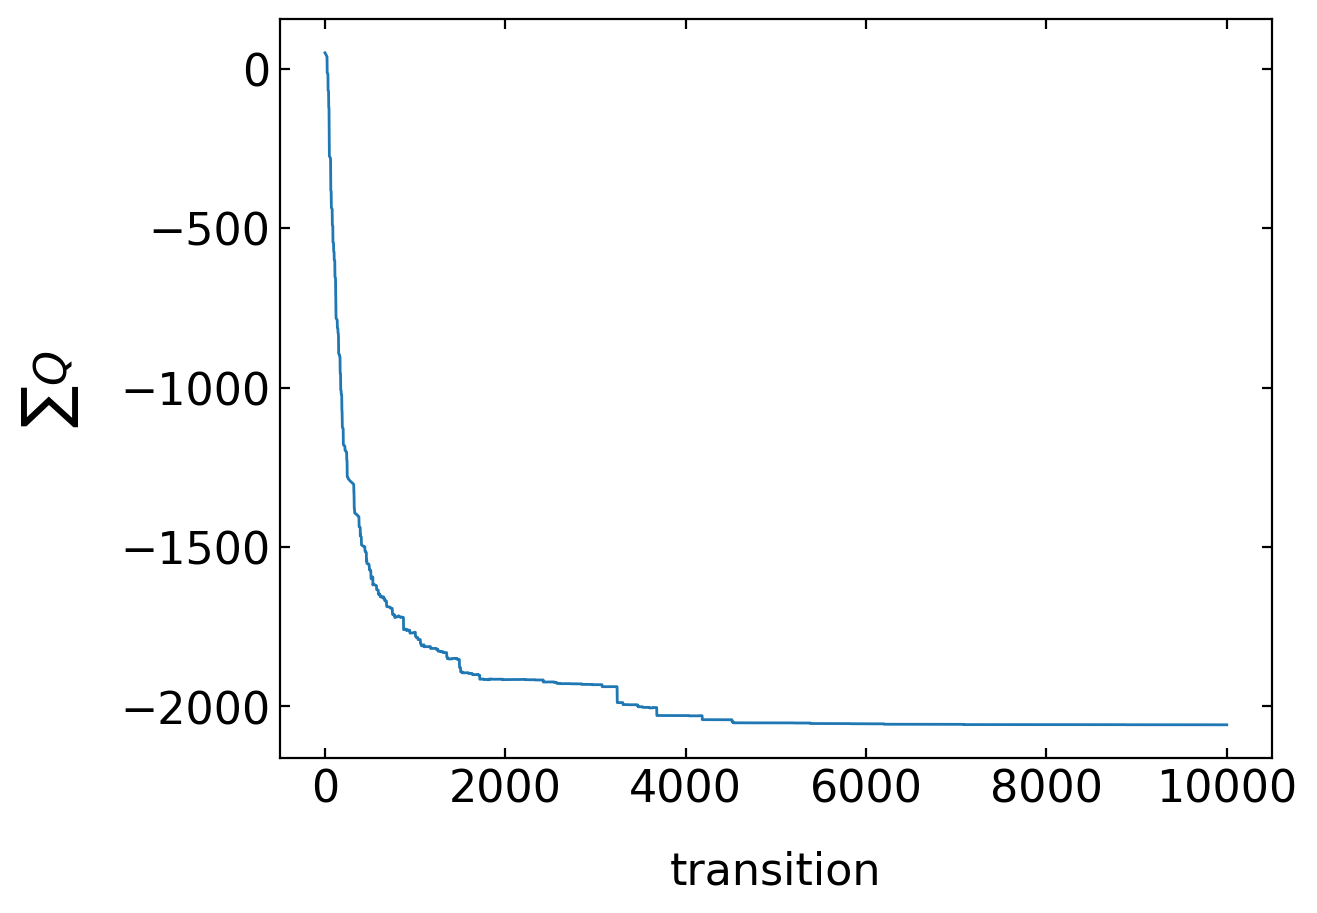

In [8]:
plt.plot(qsum)
plt.xlabel('transition')
plt.ylabel(r'$\sum Q$')
plt.show()

### Policy

The policy is obtained by taking the best actions with the larges Q-value from our Q-matrix.

$$
\pi^{*}(s)={\rm argmax_{a}}Q^{*}(s,a)
$$

In [10]:
policy=np.argmax(Q[:,:,:],axis=2)
policy[n_rows-1,n_columns-1]=-1

### Plot the policy

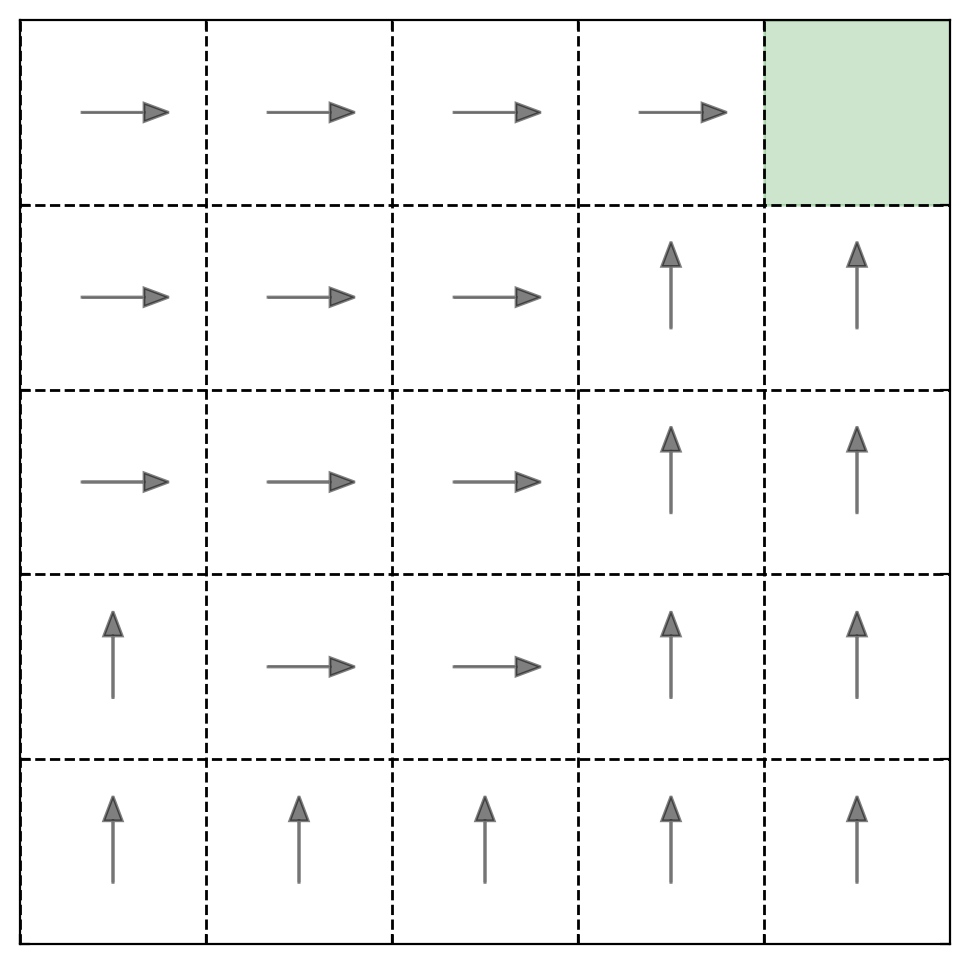

In [12]:
f,ax=plt.subplots(1,figsize=(6,6))

f=plt.gca()
i=0
for k,y in enumerate(range(3,n_rows*6,6)):
    for l,x in enumerate(range(3,n_columns*6,6)):
        if policy[k,l]!=-1:
            vec=acl[policy[k,l]]*2       
            if i!=n_rows*n_columns:  
                plt.arrow(x-vec[1]/2, y-vec[0]/2, vec[1], vec[0], fc="k", ec="k",head_width=0.6, head_length=0.8, width=0.01 ,alpha=0.5)
       
        else:
            rect=patches.Rectangle((x-3,y-3), 6,6,color='green',alpha=0.2)
            ax.add_patch(rect)
        i=i+1
        
plt.xticks(np.arange(0, n_rows*n_columns, step=6))
plt.yticks(np.arange(0, n_rows*n_columns, step=6))
plt.xlim(0,6*n_columns)
plt.ylim(0,6*n_rows)
plt.grid(lw=1,color='k',ls='--')  

f.axes.xaxis.set_ticklabels([])
f.axes.yaxis.set_ticklabels([])
plt.show() 

## Where to go from here

If you want to know more about Reinforcement Learning, have a look at the [book](http://incompleteideas.net/book/bookdraft2017nov5.pdf) of Sutton and Barto.